In [2]:
%load_ext autoreload
%autoreload 2

# Week 2: Getting Started with Re-ranker Fine-tuning

> **Prerequisites**: Complete the `1. Synthetic Transactions.ipynb` notebook first to generate the evaluation dataset we'll use for fine-tuning. You'll also need a Cohere API Key which you can get by signing up for a free account on [Cohere](https://cohere.com/).

When improving RAG systems, starting with a managed re-ranker service can provide quick wins with minimal engineering overhead. This notebook demonstrates how to fine-tune a Cohere re-ranker for better retrieval performance using just a few hundred examples.

## Why This Matters

Re-rankers offer several advantages when you're just getting started:

1. **Data Efficiency**
   - Work effectively with limited data (as few as 256 examples)
   - Only need to learn ranking within small candidate sets  
   - Can achieve significant gains without massive training sets

2. **Easy Integration** 
   - Drop-in addition to existing retrieval pipelines
   - Progressive improvement without system overhauls
   - No need to re-embed your entire document collection

3. **Quick Implementation**
   - Hosted services handle infrastructure complexity
   - No hyperparameter tuning required  
   - Focus on experimentation rather than deployment

## What You'll Learn

Through hands-on examples, you'll discover how to:

1. **Prepare Training Data**
   - Format data for re-ranker fine-tuning
   - Create effective training examples
   - Generate hard negatives

2. **Fine-tune Models**
   - Configure training parameters
   - Monitor training progress
   - Validate model improvements

3. **Evaluate Performance**
   - Compare against baseline retrieval
   - Measure recall and MRR improvements
   - Analyze result quality

By the end of this notebook, you'll have a fine-tuned re-ranker improving your retrieval results. This builds on Week 1's evaluation framework while preparing you for more advanced fine-tuning using open-source models in notebook 3.




## Preparing Our Training Data

In this notebook, we'll be using the synthetic transactions dataset we created in the previous notebook to fine-tune a Cohere re-ranker. We'll be using the `rerank-english-v3.0` model as our base model and creating a dataset with hard negatives so that oure-reanker learns the difference between similar categories.

### Hard Negatives

A key aspect of effective re-ranker training is the selection of hard negatives - examples that are similar to the correct answer but shouldn't be ranked highly. For instance:

Query:
```
Name: Ayden
Category: Financial Software
Department: Finance
Location: Berlin, DE
Amount: 1273.45
```

Positive Example:
```
Subscription & Revenue Infrastructure
```

Hard Negatives:
```
Office Equipment Maintenance
Office Supplies & Stationery
Human Resources
```

Hard negatives help your model by:
1. Improving discriminative ability between similar categories
2. Building robustness against noisy results
3. Making efficient use of limited training data


### Creating Our Dataset

In this section, we'll use the examples that we previously stored in Braintrust to create a dataset to train our re-ranker. We'll use the `train` examples to train our re-ranker and the `eval` examples to benchmark our model. Once we've formatted our data in the correct format, we'll save it to a file and upload it to Cohere.

In [2]:
from braintrust import init_dataset

dataset = init_dataset(project="fine-tuning", name="Synthetic Transactions")


def get_dataset_split(split: str, dataset):
    return [
        {
            "input": transaction["input"],
            "expected": transaction["expected"],
        }
        for transaction in dataset
        if transaction["metadata"]["split"] == split
    ]


train_data = get_dataset_split("train", dataset)
eval_data = get_dataset_split("eval", dataset)

In [3]:
from pydantic import BaseModel


# Define Pydantic model to store our finetuning data
class FinetuneItem(BaseModel):
    query: str
    relevant_passages: list[str]
    hard_negatives: list[str]


# Get all the labels in our dataset
labels = set([transaction["expected"][0] for transaction in train_data])

In [8]:
import random

finetuning_data = [
    FinetuneItem(
        query=transaction["input"],
        relevant_passages=[transaction["expected"][0]],
        hard_negatives=random.sample(
            [label for label in labels if label != transaction["expected"][0]], k=4
        ),
    )
    for transaction in train_data
    # Generate 2 samples with 4 hard negatives each for each transaction
    for _ in range(2)
]

with open("./data/cohere_finetune.jsonl", "w") as f:
    for item in finetuning_data:
        f.write(item.model_dump_json() + "\n")

## Finetuning Our Model

Now that we've created our dataset, we can upload it to Cohere and kick off our fine-tuning job. 

### Uploading Our Dataset

A reminder that the fine-tuning itself will take around 1 hour to a day so you'll need to come back to this notebook later down the line when this is done.

Once the dataset has a status `validated`, we can kick off our fine-tuning job.

In [9]:
import cohere

co = cohere.ClientV2()

reranked_dataset = co.datasets.create(
    name="Synthetic Transactions Finetune",
    data=open("./data/cohere_finetune.jsonl", "rb"),
    type="reranker-finetune-input",
)

co.wait(reranked_dataset).dataset.validation_status


...
...
...


'validated'

### Submitting Our Finetuning Job

Now that we've uploaded our dataset, we can kick off our fine-tuning job. Make sure to indicate that you're doing a re-ranker finetune when creating the job. You can check the status of your job at any time by calling `co.finetuning.get_finetuned_model` or visiting the Cohere dashboard.

In [25]:
from cohere.finetuning import BaseModel, FinetunedModel, Settings

finetune_request = co.finetuning.create_finetuned_model(
    request=FinetunedModel(
        name="finetuned-cohere-reranker",
        settings=Settings(
            base_model=BaseModel(base_type="BASE_TYPE_RERANK"),
            dataset_id=reranked_dataset.id,
        ),
    )
)

In [29]:
response = co.finetuning.get_finetuned_model(finetune_request.finetuned_model.id)
response.finetuned_model.status

'STATUS_READY'

## Benchmarking our Model

We want to quantify the improvement that fine-tuning a model gets us. In order to do so, we'll be using the same retrieval evals as before to benchmark our fine-tuned model. Since we're building a model here that will suggest relevant categories for a given transaction, we'll be measuring the following two metrics.    

- Recall : Whether the correct category is in the top N results
- MRR : The mean reciprocal rank of the correct category in the top N results

We want to mainly measure two things

- How much of an improvement does a fine-tuned model get us over a pure embedding based approach
- How does the fine-tuned model perform against the default Cohere re-ranker

In order to do so, we'll be benchmarking our fine-tuned model against the default text-embedding-3-small model as well as the default Cohere re-ranker. We'll use `braintrust` here to run our evaluations and compare the results between our different configurations since it's where we've stored our evaluation data and provides an easy way to share our results with others.



In [5]:
import lancedb

db = lancedb.connect("./lancedb")
table = db.open_table("categories")

In [11]:
from braintrust import Eval, Score
from lancedb.rerankers import CohereReranker
from helpers import get_metrics_at_k, task


def evaluate_braintrust(input, output, **kwargs):
    metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])
    return [
        Score(
            name=metric,
            score=score_fn(output, kwargs["expected"]),
            metadata={"query": input, "result": output, **kwargs["metadata"]},
        )
        for metric, score_fn in metrics.items()
    ]

rerankers = [
    # Remember to replace this with your fine-tuned model id
    CohereReranker(model_name="0486d248-8476-40f6-a5bf-1ef6fd8a65dd-ft"),
    CohereReranker(model_name="rerank-english-v3.0"),
    None,
]

results = []

for reranker in rerankers:
    results.append(
        await Eval(
            "fine-tuning",  # Replace with your project name
            data=eval_data, # We're using the eval data here to do the benchmarking
            task=lambda query: task(user_query=query, table=table, reranker=reranker, max_k=25),  # Replace with your LLM call
            scores=[evaluate_braintrust],
        )
    )

Experiment remove-braintrust-1739784768 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/remove-braintrust-1739784768
fine-tuning (data): 66it [00:00, 47860.32it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
remove-braintrust-1739784768 compared to synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-test:
83.33% (+25.76%) 'mrr@1'    score	(19 improvements, 2 regressions)
88.38% (+17.17%) 'mrr@3'    score	(21 improvements, 4 regressions)
89.29% (+16.72%) 'mrr@5'    score	(22 improvements, 5 regressions)
83.33% (+25.76%) 'recall@1' score	(19 improvements, 2 regressions)
93.94% (+07.58%) 'recall@3' score	(6 improvements, 1 regressions)
98.48% (+06.06%) 'recall@5' score	(4 improvements, 0 regressions)

1739784768.64s start
1739784771.26s end
1.93s (+61.04%) 'duration'	(26 improvements, 40 regressions)

See results for remove-braintrust-1739784768 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/remove-braintrust-1739784768


Experiment remove-braintrust-1739784800 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/remove-braintrust-1739784800
fine-tuning (data): 66it [00:00, 52250.67it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
remove-braintrust-1739784800 compared to synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-test:
24.24% (-33.33%) 'mrr@1'    score	(1 improvements, 23 regressions)
28.79% (-42.42%) 'mrr@3'    score	(1 improvements, 41 regressions)
30.15% (-42.42%) 'mrr@5'    score	(1 improvements, 45 regressions)
24.24% (-33.33%) 'recall@1' score	(1 improvements, 23 regressions)
34.85% (-51.52%) 'recall@3' score	(0 improvements, 34 regressions)
40.91% (-51.52%) 'recall@5' score	(0 improvements, 34 regressions)

1739784800.43s start
1739784803.74s end
2.37s (+105.18%) 'duration'	(21 improvements, 45 regressions)

See results for remove-braintrust-1739784800 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/remove-braintrust-1739784800


Experiment remove-braintrust-1739784832 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/remove-braintrust-1739784832
fine-tuning (data): 66it [00:00, 48001.40it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
remove-braintrust-1739784832 compared to synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-test:
39.39% (-18.18%) 'mrr@1'    score	(7 improvements, 19 regressions)
51.77% (-19.44%) 'mrr@3'    score	(9 improvements, 28 regressions)
54.19% (-18.38%) 'mrr@5'    score	(10 improvements, 31 regressions)
39.39% (-18.18%) 'recall@1' score	(7 improvements, 19 regressions)
66.67% (-19.70%) 'recall@3' score	(2 improvements, 15 regressions)
77.27% (-15.15%) 'recall@5' score	(2 improvements, 12 regressions)

1739784832.36s start
1739784833.76s end
0.91s (-40.73%) 'duration'	(62 improvements, 4 regressions)

See results for remove-braintrust-1739784832 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/remove-braintrust-1739784832


In [7]:
from concurrent.futures import ThreadPoolExecutor
from helpers import task, get_metrics_at_k
import pandas as pd

metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])


def evaluate_query(output, expense_category):
    scores = {}
    for metric, score_fn in metrics.items():
        scores[metric] = score_fn(output, expense_category)

    return scores

rerankers = [
    # Remember to replace this with your fine-tuned model id
    ["fine-tuned", CohereReranker(model_name="0486d248-8476-40f6-a5bf-1ef6fd8a65dd-ft")],
    ["default", CohereReranker(model_name="rerank-english-v3.0")],
    ["no-reranker", None],
]

results = {}

with ThreadPoolExecutor(max_workers=10) as executor:
    for reranker_name, reranker in rerankers:
        query_results = list(
            executor.map(
                    lambda q: task(
                    user_query=q["input"], table=table, reranker=reranker, max_k=25
                ),
                eval_data,
            )
        )
        scores = [
            evaluate_query(output, transaction["expected"])
            for output, transaction in zip(query_results, eval_data)
        ]
        df = pd.DataFrame(scores)
        results[reranker_name] = round(pd.DataFrame(scores).mean(), 4)
        print(results[reranker_name])

mrr@1       0.8333
mrr@3       0.8838
mrr@5       0.8929
recall@1    0.8333
recall@3    0.9394
recall@5    0.9848
dtype: float64
mrr@1       0.2424
mrr@3       0.2879
mrr@5       0.3015
recall@1    0.2424
recall@3    0.3485
recall@5    0.4091
dtype: float64
mrr@1       0.3939
mrr@3       0.5177
mrr@5       0.5419
recall@1    0.3939
recall@3    0.6667
recall@5    0.7727
dtype: float64


### Analysing Our Results

Now that we've run our evaluations, let's take a closer look at the results. We want to compare the performance of our fine-tuned model against the default Cohere re-ranker as well as the default vector search baseline without a re-ranker.

In [12]:
import pandas as pd
scores = []

for result in results:
    result_scores = {}
    for score_name, score in result.summary.scores.items():
        result_scores[score_name] = score.score
    scores.append(result_scores)

df = pd.DataFrame(scores,index=["Fine-Tuned Reranker", "Default Reranker", "No Reranker"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Fine-Tuned Reranker,0.83,0.88,0.89,0.83,0.94,0.98
Default Reranker,0.24,0.29,0.30,0.24,0.35,0.41
No Reranker,0.39,0.52,0.54,0.39,0.67,0.77


In [10]:
df = pd.DataFrame(results.values(), index=["Fine-Tuned Reranker", "Default Reranker", "No Reranker"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Fine-Tuned Reranker,0.83,0.88,0.89,0.83,0.94,0.98
Default Reranker,0.24,0.29,0.30,0.24,0.35,0.41
No Reranker,0.39,0.52,0.54,0.39,0.67,0.77


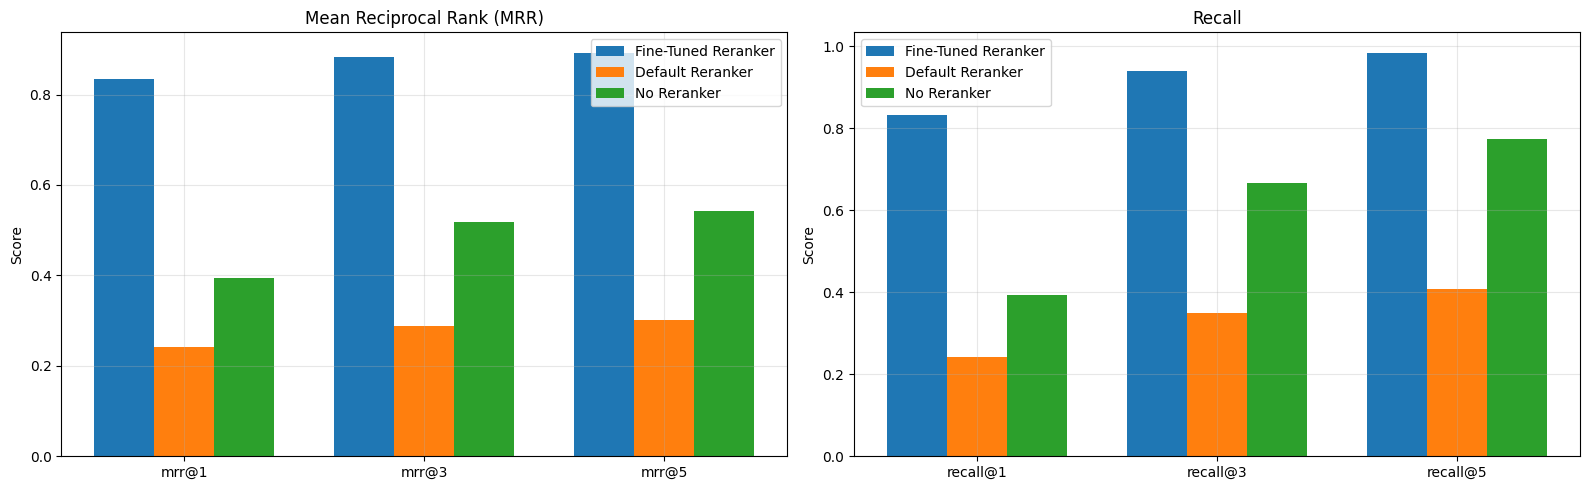

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot MRR scores
mrr_cols = ['mrr@1', 'mrr@3', 'mrr@5']
x = np.arange(len(mrr_cols))
width = 0.25

for i, model in enumerate(df.index):
    offset = (i - 1) * width
    ax1.bar(x + offset, df.loc[model, mrr_cols], width, label=model)

ax1.set_title('Mean Reciprocal Rank (MRR)')
ax1.set_xticks(x)
ax1.set_xticklabels(mrr_cols)
ax1.set_ylabel('Score')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Recall scores
recall_cols = ['recall@1', 'recall@3', 'recall@5']
x = np.arange(len(recall_cols))

for i, model in enumerate(df.index):
    offset = (i - 1) * width
    ax2.bar(x + offset, df.loc[model, recall_cols], width, label=model)

ax2.set_title('Recall')
ax2.set_xticks(x)
ax2.set_xticklabels(recall_cols)
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we demonstrated how fine-tuning a Cohere re-ranker can significantly improve retrieval performance. With just 256 synthetic examples, our fine-tuned model showed a 60% increase in recall and a 49% increase in mean reciprocal rank (MRR) compared to the text-embedding-3-small model.

This substantial improvement highlights two key considerations for future fine-tuning efforts:

1. **Model Selection**: Explore various re-ranker options, including English and multi-lingual models from providers like Cohere and Jina. Experiment to find the best fit for your specific use case.

2. **Dataset Quality**: Move beyond simple random negative selection. Consider more sophisticated approaches like using cosine similarity or leveraging language models to identify hard negatives.

The fast, objective metrics we established in Week 1 were crucial in our analysis. They allowed us to quickly benchmark our fine-tuned model against both the default Cohere re-ranker and the text-embedding-3-small model. Surprisingly, we discovered that the default Cohere re-ranker actually degraded performance while increasing latency.

In Week 4, we'll use similar approaches to discover query patterns with BERTopic, and in Week 5, we'll apply these techniques to structured data and metadata. These are applications where a fine-tuned re-ranker can provide a significant improvement for, especially when at the start when we have a limited amount of user data.As you accumulate more user data, that's when you might want to start looking at fine-tuning an open-source model using the Sentence Transformers library which introduces new challenges such as managing hyper-parameters, loss functions and training loops which we'll explore in the next notebook.